# Streaming flow policy in the Push-T environment
```{note}
*This notebook is adapted from [Diffusion policy's Colab notebook](https://colab.research.google.com/drive/1gxdkgRVfM55zihY9TFLja97cSVZOZq2B?usp=sharing) with an implementation of [Streaming flow policy](https://streaming-flow-policy.github.io/).*
```

In [1]:
# Standard imports
import collections
from dataclasses import dataclass
import gdown
import os
import numpy as np
import math
import torch
from torch import Tensor
import torch.nn as nn
from tqdm.auto import tqdm
from typing import List, Literal, Sequence, Tuple, Union

# Imports for diffusion policy
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

# Imports for the Push-T environment
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
import jupyviz as jviz

# always call this first
from streaming_flow_policy.all import set_random_seed
set_random_seed(0)

/home/sancha/repos/streaming-flow-policy/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## **Push-T environment in PyMunk**
Here, we define a PyMunk-based `PushTEnv` environment.
This implementation is adapted from [Diffusion policy](https://diffusion-policy.cs.columbia.edu/), which in turn is adapted from [Implicit Behavior Cloning](https://implicitbc.github.io/).
The goal is to push the gray T-block to its target position and orientation denoted in green.

<img src="./pusht.png" width="256px" style="display: block; margin-left: auto; margin-right: auto;" class="centered">

In [2]:
positive_y_is_up: bool = False
"""Make increasing values of y point upwards.

When True::            When False::

    y                   +------ > x
    ^                   |
    |      . (3, 3)     |   . (2, 2)
    |                   |
    |   . (2, 2)        |      . (3, 3)
    |                   v
    +------ > x         y
"""

def to_pygame(p: Tuple[float, float], surface: pygame.Surface) -> Tuple[int, int]:
    """Convenience method to convert pymunk coordinates to pygame surface
    local coordinates.

    Note that in case positive_y_is_up is False, this function wont actually do
    anything except converting the point to integers.
    """
    if positive_y_is_up:
        return round(p[0]), surface.get_height() - round(p[1])
    else:
        return round(p[0]), round(p[1])


def light_color(color: SpaceDebugColor):
    color = np.minimum(1.2 * np.float32([color.r, color.g, color.b, color.a]), np.float32([255]))
    color = SpaceDebugColor(r=color[0], g=color[1], b=color[2], a=color[3])
    return color

class DrawOptions(pymunk.SpaceDebugDrawOptions):
    def __init__(self, surface: pygame.Surface) -> None:
        """Draw a pymunk.Space on a pygame.Surface object.

        Typical usage::

        >>> import pymunk
        >>> surface = pygame.Surface((10,10))
        >>> space = pymunk.Space()
        >>> options = pymunk.pygame_util.DrawOptions(surface)
        >>> space.debug_draw(options)

        You can control the color of a shape by setting shape.color to the color
        you want it drawn in::

        >>> c = pymunk.Circle(None, 10)
        >>> c.color = pygame.Color("pink")

        See pygame_util.demo.py for a full example

        Since pygame uses a coordiante system where y points down (in contrast
        to many other cases), you either have to make the physics simulation
        with Pymunk also behave in that way, or flip everything when you draw.

        The easiest is probably to just make the simulation behave the same
        way as Pygame does. In that way all coordinates used are in the same
        orientation and easy to reason about::

        >>> space = pymunk.Space()
        >>> space.gravity = (0, -1000)
        >>> body = pymunk.Body()
        >>> body.position = (0, 0) # will be positioned in the top left corner
        >>> space.debug_draw(options)

        To flip the drawing its possible to set the module property
        :py:data:`positive_y_is_up` to True. Then the pygame drawing will flip
        the simulation upside down before drawing::

        >>> positive_y_is_up = True
        >>> body = pymunk.Body()
        >>> body.position = (0, 0)
        >>> # Body will be position in bottom left corner

        :Parameters:
                surface : pygame.Surface
                    Surface that the objects will be drawn on
        """
        self.surface = surface
        super(DrawOptions, self).__init__()

    def draw_circle(
        self,
        pos: Vec2d,
        angle: float,
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p = to_pygame(pos, self.surface)

        pygame.draw.circle(self.surface, fill_color.as_int(), p, round(radius), 0)
        pygame.draw.circle(self.surface, light_color(fill_color).as_int(), p, round(radius-4), 0)

        circle_edge = pos + Vec2d(radius, 0).rotated(angle)
        p2 = to_pygame(circle_edge, self.surface)
        line_r = 2 if radius > 20 else 1
        # pygame.draw.lines(self.surface, outline_color.as_int(), False, [p, p2], line_r)

    def draw_segment(self, a: Vec2d, b: Vec2d, color: SpaceDebugColor) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        pygame.draw.aalines(self.surface, color.as_int(), False, [p1, p2])

    def draw_fat_segment(
        self,
        a: Tuple[float, float],
        b: Tuple[float, float],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        p1 = to_pygame(a, self.surface)
        p2 = to_pygame(b, self.surface)

        r = round(max(1, radius * 2))
        pygame.draw.lines(self.surface, fill_color.as_int(), False, [p1, p2], r)
        if r > 2:
            orthog = [abs(p2[1] - p1[1]), abs(p2[0] - p1[0])]
            if orthog[0] == 0 and orthog[1] == 0:
                return
            scale = radius / (orthog[0] * orthog[0] + orthog[1] * orthog[1]) ** 0.5
            orthog[0] = round(orthog[0] * scale)
            orthog[1] = round(orthog[1] * scale)
            points = [
                (p1[0] - orthog[0], p1[1] - orthog[1]),
                (p1[0] + orthog[0], p1[1] + orthog[1]),
                (p2[0] + orthog[0], p2[1] + orthog[1]),
                (p2[0] - orthog[0], p2[1] - orthog[1]),
            ]
            pygame.draw.polygon(self.surface, fill_color.as_int(), points)
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p1[0]), round(p1[1])),
                round(radius),
            )
            pygame.draw.circle(
                self.surface,
                fill_color.as_int(),
                (round(p2[0]), round(p2[1])),
                round(radius),
            )

    def draw_polygon(
        self,
        verts: Sequence[Tuple[float, float]],
        radius: float,
        outline_color: SpaceDebugColor,
        fill_color: SpaceDebugColor,
    ) -> None:
        ps = [to_pygame(v, self.surface) for v in verts]
        ps += [ps[0]]

        radius = 2
        pygame.draw.polygon(self.surface, light_color(fill_color).as_int(), ps)

        if radius > 0:
            for i in range(len(verts)):
                a = verts[i]
                b = verts[(i + 1) % len(verts)]
                self.draw_fat_segment(a, b, radius, fill_color, fill_color)

    def draw_dot(
        self, size: float, pos: Tuple[float, float], color: SpaceDebugColor
    ) -> None:
        p = to_pygame(pos, self.surface)
        pygame.draw.circle(self.surface, color.as_int(), p, round(size), 0)

def pymunk_to_shapely(body, shapes):
    geoms = list()
    for shape in shapes:
        if isinstance(shape, pymunk.shapes.Poly):
            verts = [body.local_to_world(v) for v in shape.get_vertices()]
            verts += [verts[0]]
            geoms.append(sg.Polygon(verts))
        else:
            raise RuntimeError(f'Unsupported shape type {type(shape)}')
    geom = sg.MultiPolygon(geoms)
    return geom

class PushTEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 10}
    reward_range = (0., 1.)

    def __init__(self,
            legacy=False,
            block_cog=None, damping=None,
            render_action=True,
            render_size=256,  # was previously 96
            reset_to_state=None
        ):
        self._seed = None
        self.seed()
        self.window_size = ws = 512  # The size of the PyGame window
        self.render_size = render_size
        self.sim_hz = 100
        # Local controller params.
        self.k_p, self.k_v = 100, 20    # PD control.z
        self.control_hz = self.metadata['video.frames_per_second']
        # legcay set_state for data compatiblity
        self.legacy = legacy

        # agent_pos, block_pos, block_angle
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0], dtype=np.float64),
            high=np.array([ws,ws,ws,ws,np.pi*2], dtype=np.float64),
            shape=(5,),
            dtype=np.float64
        )

        # positional goal for agent
        self.action_space = spaces.Box(
            low=np.array([0,0], dtype=np.float64),
            high=np.array([ws,ws], dtype=np.float64),
            shape=(2,),
            dtype=np.float64
        )

        self.block_cog = block_cog
        self.damping = damping
        self.render_action = render_action

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None
        self.screen = None

        self.space = None
        self.teleop = None
        self.render_buffer = None
        self.latest_action = None
        self.reset_to_state = reset_to_state

    def reset(self):
        seed = self._seed
        self._setup()
        if self.block_cog is not None:
            self.block.center_of_gravity = self.block_cog
        if self.damping is not None:
            self.space.damping = self.damping

        # use legacy RandomState for compatiblity
        state = self.reset_to_state
        if state is None:
            rs = np.random.RandomState(seed=seed)
            state = np.array([
                rs.randint(50, 450), rs.randint(50, 450),
                rs.randint(100, 400), rs.randint(100, 400),
                rs.randn() * 2 * np.pi - np.pi
                ])
        self._set_state(state)

        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action):
        dt = 1.0 / self.sim_hz
        self.n_contact_points = 0
        n_steps = self.sim_hz // self.control_hz
        if action is not None:
            self.latest_action = action
            for i in range(n_steps):
                # Step PD control.
                # self.agent.velocity = self.k_p * (act - self.agent.position)    # P control works too.
                acceleration = self.k_p * (action - self.agent.position) + self.k_v * (Vec2d(0, 0) - self.agent.velocity)
                self.agent.velocity += acceleration * dt

                # Step physics.
                self.space.step(dt)

        # compute reward
        goal_body = self._get_goal_pose_body(self.goal_pose)
        goal_geom = pymunk_to_shapely(goal_body, self.block.shapes)
        block_geom = pymunk_to_shapely(self.block, self.block.shapes)

        intersection_area = goal_geom.intersection(block_geom).area
        goal_area = goal_geom.area
        coverage = intersection_area / goal_area
        reward = np.clip(coverage / self.success_threshold, 0, 1)
        done = coverage > self.success_threshold
        terminated = done
        truncated = done

        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info

    def render(self, mode="rgb_array"):
        return self._render_frame(mode)

    def teleop_agent(self):
        TeleopAgent = collections.namedtuple('TeleopAgent', ['act'])
        def act(obs):
            act = None
            mouse_position = pymunk.pygame_util.from_pygame(Vec2d(*pygame.mouse.get_pos()), self.screen)
            if self.teleop or (mouse_position - self.agent.position).length < 30:
                self.teleop = True
                act = mouse_position
            return act
        return TeleopAgent(act)

    def _get_obs(self):
        obs = np.array(
            tuple(self.agent.position) \
            + tuple(self.block.position) \
            + (self.block.angle % (2 * np.pi),))
        return obs

    def _get_goal_pose_body(self, pose):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (50, 100))
        body = pymunk.Body(mass, inertia)
        # preserving the legacy assignment order for compatibility
        # the order here dosn't matter somehow, maybe because CoM is aligned with body origin
        body.position = pose[:2].tolist()
        body.angle = pose[2]
        return body

    def _get_info(self):
        n_steps = self.sim_hz // self.control_hz
        n_contact_points_per_step = int(np.ceil(self.n_contact_points / n_steps))
        info = {
            'pos_agent': np.array(self.agent.position),
            'vel_agent': np.array(self.agent.velocity),
            'block_pose': np.array(list(self.block.position) + [self.block.angle]),
            'goal_pose': self.goal_pose,
            'n_contacts': n_contact_points_per_step}
        return info

    def _render_frame(self, mode):

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        self.screen = canvas

        draw_options = DrawOptions(canvas)

        # Draw goal pose.
        goal_body = self._get_goal_pose_body(self.goal_pose)
        for shape in self.block.shapes:
            goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
            goal_points += [goal_points[0]]
            pygame.draw.polygon(canvas, self.goal_color, goal_points)

        # Draw agent and block.
        self.space.debug_draw(draw_options)

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # the clock is aleady ticked during in step for "human"

        img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        img = cv2.resize(img, (self.render_size, self.render_size))
        if self.render_action:
            if self.render_action and (self.latest_action is not None):
                action = np.array(self.latest_action)
                coord = (action / self.window_size * self.render_size).astype(np.int32)
                marker_size = int(8 /96 *self.render_size)
                thickness = int(1 / 96 * self.render_size)
                cv2.drawMarker(img, coord,
                    color=(255,0,0), markerType=cv2.MARKER_CROSS,
                    markerSize=marker_size, thickness=thickness)
        return img

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

    def seed(self, seed=None):
        if seed is None:
            seed = np.random.randint(0,25536)
        self._seed = seed
        self.np_random = np.random.default_rng(seed)

    def _handle_collision(self, arbiter, space, data):
        self.n_contact_points += len(arbiter.contact_point_set.points)

    def _set_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.tolist()
        pos_agent = state[:2]
        pos_block = state[2:4]
        rot_block = state[4]
        self.agent.position = pos_agent
        # setting angle rotates with respect to center of mass
        # therefore will modify the geometric position
        # if not the same as CoM
        # therefore should be modified first.
        if self.legacy:
            # for compatiblity with legacy data
            self.block.position = pos_block
            self.block.angle = rot_block
        else:
            self.block.angle = rot_block
            self.block.position = pos_block

        # Run physics to take effect
        self.space.step(1.0 / self.sim_hz)

    def _set_state_local(self, state_local):
        agent_pos_local = state_local[:2]
        block_pose_local = state_local[2:]
        tf_img_obj = st.AffineTransform(
            translation=self.goal_pose[:2],
            rotation=self.goal_pose[2])
        tf_obj_new = st.AffineTransform(
            translation=block_pose_local[:2],
            rotation=block_pose_local[2]
        )
        tf_img_new = st.AffineTransform(
            matrix=tf_img_obj.params @ tf_obj_new.params
        )
        agent_pos_new = tf_img_new(agent_pos_local)
        new_state = np.array(
            list(agent_pos_new[0]) + list(tf_img_new.translation) \
                + [tf_img_new.rotation])
        self._set_state(new_state)
        return new_state

    def _setup(self):
        self.space = pymunk.Space()
        self.space.gravity = 0, 0
        self.space.damping = 0
        self.teleop = False
        self.render_buffer = list()

        # Add walls.
        walls = [
            self._add_segment((5, 506), (5, 5), 2),
            self._add_segment((5, 5), (506, 5), 2),
            self._add_segment((506, 5), (506, 506), 2),
            self._add_segment((5, 506), (506, 506), 2)
        ]
        self.space.add(*walls)

        # Add agent, block, and goal zone.
        self.agent = self.add_circle((256, 400), 15)
        self.block = self.add_tee((256, 300), 0)
        self.goal_color = pygame.Color('LightGreen')
        self.goal_pose = np.array([256,256,np.pi/4])  # x, y, theta (in radians)

        # Add collision handling
        self.space.on_collision(0, 0, post_solve=self._handle_collision)

        self.n_contact_points = 0
        self.max_score = 50 * 100
        self.success_threshold = 0.95    # 95% coverage.

    def _add_segment(self, a, b, radius):
        shape = pymunk.Segment(self.space.static_body, a, b, radius)
        shape.color = pygame.Color('LightGray')    # https://htmlcolorcodes.com/color-names
        return shape

    def add_circle(self, position, radius):
        body = pymunk.Body(body_type=pymunk.Body.KINEMATIC)
        body.position = position
        body.friction = 1
        shape = pymunk.Circle(body, radius)
        shape.color = pygame.Color('RoyalBlue')
        self.space.add(body, shape)
        return body

    def add_box(self, position, height, width):
        mass = 1
        inertia = pymunk.moment_for_box(mass, (height, width))
        body = pymunk.Body(mass, inertia)
        body.position = position
        shape = pymunk.Poly.create_box(body, (height, width))
        shape.color = pygame.Color('LightSlateGray')
        self.space.add(body, shape)
        return body

    def add_tee(self, position, angle, scale=30, color='LightSlateGray', mask=pymunk.ShapeFilter.ALL_MASKS()):
        mass = 1
        length = 4
        vertices1 = [(-length*scale/2, scale),
                                 ( length*scale/2, scale),
                                 ( length*scale/2, 0),
                                 (-length*scale/2, 0)]
        inertia1 = pymunk.moment_for_poly(mass, vertices=vertices1)
        vertices2 = [(-scale/2, scale),
                                 (-scale/2, length*scale),
                                 ( scale/2, length*scale),
                                 ( scale/2, scale)]
        inertia2 = pymunk.moment_for_poly(mass, vertices=vertices1)
        body = pymunk.Body(mass, inertia1 + inertia2)
        shape1 = pymunk.Poly(body, vertices1)
        shape2 = pymunk.Poly(body, vertices2)
        shape1.color = pygame.Color(color)
        shape2.color = pygame.Color(color)
        shape1.filter = pymunk.ShapeFilter(mask=mask)
        shape2.filter = pymunk.ShapeFilter(mask=mask)
        body.center_of_gravity = (shape1.center_of_gravity + shape2.center_of_gravity) / 2
        body.position = position
        body.angle = angle
        body.friction = 1
        self.space.add(body, shape1, shape2)
        return body

`PushTEnv` follows the standard OpenAI Gym API (0.21.0). Here's an illustration of the basic API calls:


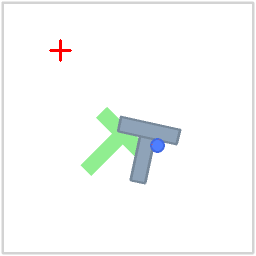

Observ:  array([314.6388, 291.4624, 301.0318, 245.9178,   0.2163])
               [agent_x,  agent_y,  block_x,  block_y,    block_angle]
Action:  array([120.8259, 101.9938]) ⟺ [target_agent_x, target_agent_y]


In [3]:
# 0. create env object
env = PushTEnv()

# 1. Seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(500)

# 2. Must reset before starting each episode.
obs, info = env.reset()

# 3. 2D positional action space [0, 512].
action = env.action_space.sample()

# 4. Stepping through environment dynamics with standard OpenAI Gym API.
obs, reward, terminated, truncated, info = env.step(action)

# 5. Render the environment.
img = env.render()  # (256, 256, 3) RGB image
jviz.img(img).html(title='Push-T render after reset').display()

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print("Observ: ", repr(obs))
    print("               [agent_x,  agent_y,  block_x,  block_y,    block_angle]")
    print("Action: ", repr(action) + " ⟺ [target_agent_x, target_agent_y]")

## **Demonstration dataset $/$ dataloader**

Defines the `PushTDataset` (a subclass of `torch.utils.data.Dataset`) and helper functions.

The dataset class:
- Load episodes i.e. sequences of (observation, action) tuples from a zarr storage.
- Normalizes each dimension of observation and action to [-1,1].
- Returns: All possible segments of length `pred_horizon`. It also pads the beginning and the end of each episode with repetition, so that each timestep has a fixed number of observation length and action length.
A dictionary is returned with the following signature:
    ```python
    {
        "obs": torch.Tensor of shape (`obs_horizon`, `obs_dim`),
        "action": torch.Tensor of shape (`pred_horizon`, `action_dim`)
    }
    ```

In [4]:
@dataclass
class SequencePointer:
    """
    Container for sample extraction pointers.
    """

    """Starting index in the original data buffer to begin extraction."""
    buffer_start_idx: int

    """Ending index in the original data buffer (exclusive) for extraction."""
    buffer_end_idx: int
    
    """Starting index within the padded sample."""
    sample_start_idx: int
    
    """Ending index within the padded sample."""
    sample_end_idx: int

    def __iter__(self):
        """Allow unpacking: buffer_start, buffer_end, sample_start, sample_end = indices"""
        return iter([self.buffer_start_idx, self.buffer_end_idx, 
                     self.sample_start_idx, self.sample_end_idx])

def create_sequence_pointers(
        episode_ends: np.ndarray, sequence_length: int,
        pad_before: int=0, pad_after: int=0,
    ) -> List[SequencePointer]:
    """
    Create sample indices for extracting sequences from episode data with padding support.
    
    This function generates indices for extracting fixed-length sequences from a dataset
    composed of multiple episodes. It handles padding at the beginning and end of episodes
    to ensure all timesteps can be used as starting points for sequences, even near episode
    boundaries.
    
    Parameters
    ----------
    episode_ends : (np.ndarray, shape=(E,))
        Array containing the end indices (one-past-the-last) for each episode.
        For example, if episodes have lengths [10, 15, 8], then episode_ends = [10, 25, 33].
    sequence_length : int
        Length of the sequences to extract from the dataset.
    pad_before : int, default=0
        Number of timesteps to pad before the episode start. This allows sequences
        to start before the actual episode data by repeating the first values of all data keys.
    pad_after : int, default=0
        Number of timesteps to pad after the episode end. This allows sequences
        to extend beyond the actual episode data by repeating the last values of all data keys.
    
    Returns
    -------
    List[SequencePointer]
        List of SequencePointer objects for extracting sequences from all episodes.
        Can be converted to numpy array using np.array(indices) for compatibility.
        
    Notes
    -----
    The function handles episode boundaries by:
    1. Computing valid start positions for sequences within each episode.
    2. Accounting for padding requirements at episode boundaries.
    3. Returning indices that can be used to extract properly padded sequences.
    
    The returned indices are designed to work with a sampling function that can
    handle the padding by repeating boundary values when accessing out-of-bounds indices.
    
    Example
    -------
    >>> episode_ends = np.array([10, 25, 33])  # 3 episodes of lengths 10, 15, 8
    >>> indices = create_sample_indices(episode_ends, sequence_length=5, pad_before=2, pad_after=1)
    >>> # Returns list of SequencePointer objects for all possible 5-step sequences
    """
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append(SequencePointer(
                buffer_start_idx,
                buffer_end_idx,
                sample_start_idx,
                sample_end_idx,
            ))
    return indices

def extract_sequence(train_data, sequence_length, ptr: SequencePointer):
    """
    Extract and pad a sequence from training data using specified indices.
    
    This function extracts a sequence from the training data buffer and applies padding
    if necessary to ensure the output has the exact sequence_length. Padding is applied
    by repeating boundary values when the sequence extends beyond the available data.
    
    Parameters
    ----------
    train_data : dict
        Dictionary containing training data arrays. Each key maps to a numpy array
        of shape (N, feature_dim) where N is the total number of timesteps.
        Common keys include 'action' and 'obs' (observations).
    sequence_length : int
        Desired length of the output sequence. All returned arrays will have
        this length in the first dimension.
    ptr : SequencePointer
        Container of sequence pointer indices for extracting and placing the
        sequence data.
    
    Returns
    -------
    dict
        Dictionary with the same keys as train_data, where each value is a numpy array
        of shape (sequence_length, feature_dim). The arrays contain the extracted data
        with appropriate padding applied.
        
    Notes
    -----
    The function handles three cases:
    1. No padding needed: When sample_start_idx=0 and sample_end_idx=sequence_length,
       the extracted data is returned as-is.
    2. Start padding: When sample_start_idx > 0, the first sample_start_idx positions
       are filled with the first value of the extracted sample.
    3. End padding: When sample_end_idx < sequence_length, positions from sample_end_idx
       to sequence_length are filled with the last value of the extracted sample.
    
    This function is typically used with indices generated by create_sample_indices()
    to handle episode boundaries and ensure consistent sequence lengths for training.
    
    Example
    -------
    >>> train_data = {'action': np.array([[1], [2], [3], [4], [5]]), 
    ...               'obs': np.array([[0.1], [0.2], [0.3], [0.4], [0.5]])}
    >>> indices = SampleIndices(buffer_start_idx=1, buffer_end_idx=4,
    ...                         sample_start_idx=2, sample_end_idx=5)
    >>> result = sample_sequence(train_data, sequence_length=6, indices)
    >>> # Extracts [2,3,4] from buffer indices 1:4, but places them at positions 2:5
    >>> # result['action'] = [[2], [2], [2], [3], [4], [4]]  # padded at start and end
    >>> # result['obs'] = [[0.2], [0.2], [0.2], [0.3], [0.4], [0.4]]  # same padding pattern
    """
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[ptr.buffer_start_idx:ptr.buffer_end_idx]
        data = sample
        if (ptr.sample_start_idx > 0) or (ptr.sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if ptr.sample_start_idx > 0:
                data[:ptr.sample_start_idx] = sample[0]
            if ptr.sample_end_idx < sequence_length:
                data[ptr.sample_end_idx:] = sample[-1]
            data[ptr.sample_start_idx:ptr.sample_end_idx] = sample
        result[key] = data
    return result

def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])  # to [0, 1]
    ndata = ndata * 2 - 1  # to [-1, 1]
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2  # to [0, 1]
    data = ndata * (stats['max'] - stats['min']) + stats['min']  # to original
    return data

class PushTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path,
                 pred_horizon, obs_horizon, action_horizon):

        # Read from zarr dataset
        dataset_root = zarr.open(dataset_path, 'r')
        
        # All demonstration episodes are concatenated in the first dimension N
        train_data = {
            'action': dataset_root['data']['action'][:],  # (N, action_dim)
            'obs': dataset_root['data']['state'][:],  # (N, obs_dim)
        }
        # Marks one-past the last index for each episode
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # |o|o|                             observations: 2
        # | |a|a|a|a|a|a|a|a|               actions executed: 8
        # |p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

        # Compute start and end of each state-action sequence,
        # also add padding such that each timestep in the dataset is seen
        self.sequence_pointers = create_sequence_pointers(
            episode_ends = episode_ends,
            sequence_length = pred_horizon,
            pad_before = obs_horizon-1,
            pad_after = action_horizon-1,
        )

        # Compute statistics and normalized data to [-1, 1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        """Count of all possible segments of the dataset"""
        return len(self.sequence_pointers)

    def __getitem__(self, idx):
        # Get the sequence pointer for this datapoint
        ptr = self.sequence_pointers[idx]

        # Get normalized data using these indices
        nsample = extract_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            ptr=ptr,
        )

        # discard unused observations
        nsample['obs'] = nsample['obs'][:self.obs_horizon,:]
        return nsample


### `PushTDataset` and dataloaders

In [5]:
# Download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# |o|o|                             observations: 2
# | |a|a|a|a|a|a|a|a|               actions executed: 8
# |p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

pred_horizon = 16
obs_horizon = 2
action_horizon = 8

# Create dataset from file
dataset = PushTDataset(
    dataset_path=dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
)
# Save training data statistics (min, max) for each dim
stats = dataset.stats

# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    pin_memory=True,  # accelerate cpu-gpu transfer
    persistent_workers=True, # don't kill worker process after each epoch
)

# Visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

Downloading...
From: https://drive.google.com/uc?id=1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t
To: /home/sancha/repos/streaming-flow-policy/notebooks/pusht/pusht_cchi_v7_replay.zarr.zip
100%|██████████| 31.1M/31.1M [00:01<00:00, 19.2MB/s]


batch['obs'].shape: torch.Size([256, 2, 5])
batch['action'].shape torch.Size([256, 16, 2])


## **Neural network architectures**

Defines a 1D UNet architecture `ConditionalUnet1D`
as the noies prediction network

Components:
- `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
- `Downsample1d` Strided convolution to reduce temporal resolution
- `Upsample1d` Transposed convolution to increase temporal resolution
- `Conv1dBlock` Conv1d --> GroupNorm --> Mish
- `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
`x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
`cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

### Architecture changes in SFP
We are able to **re-use existing diffusion $/$ flow policy architectures** with the following changes:
- Add `scale` parameter to `SinusoidalPosEmb`.
  - <u>*Reason:*</u> Diffusion policy embeds integer diffusion timesteps on the order of 0 to 100, whereas flow policies use a unit interval $[0, 1]$ for time. For compatibility, we scale the unit interval by 100.
- Define the two additional modules `LinearDownsample1d` and `LinearUpsample1d`.
  - <u>*Reason:*</u> Diffusion policy diffuses in the space of action *sequences*, which are processed with 1-D convolutions using `ConvUpsample1d` and `ConvDownsample1d`. However, SFP diffuses in the space of *single actions*. Therefore, we introduce a fully-connected upsampler$/$downsampler that acts on single actions.

In [6]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, scale = 1):
        super().__init__()
        self.dim = dim
        self.scale = scale # added - SFP

    def forward(self, x):
        x = x * self.scale
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ConvDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class ConvUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)

class LinearDownsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class LinearUpsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, dim)

    def forward(self, x: Tensor):
        # Reshape input to (batch_size, -1) for fully connected layer
        batch_size, channels, seq_len = x.size()
        x = x.view(batch_size, -1)  # flatten spatial dimensions
        x = self.linear(x)
        x = x.view(batch_size, channels, seq_len)  # reshape back to original dimensions
        return x

class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)

class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8,
                 ):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # Ensure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out

class ConditionalUnet1D (nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        updownsample_type: Literal['Conv', 'Linear'],  # added for SFP
        sin_embedding_scale,  # added for SFP
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8,
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed, scale = sin_embedding_scale), # added - SFP
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                downsample_layer = LinearDownsample1d(dim_out) if not is_last else nn.Identity() #added
            elif updownsample_type == 'Conv':
                downsample_layer = ConvDownsample1d(dim_out) if not is_last else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                downsample_layer,
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            if updownsample_type == 'Linear':  # added for SFP
                upsample_layer = LinearUpsample1d(dim_in) if not is_last  else nn.Identity()
            elif updownsample_type == 'Conv':
                upsample_layer = ConvUpsample1d(dim_in) if not is_last  else nn.Identity()
            else:
                raise ValueError(f"Unsupported updownsample_type: {updownsample_type}")
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                upsample_layer,
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("Number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: Tensor,
            timestep: Union[Tensor, float, int],
            global_cond=None,
        ) -> Tensor:
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


### Test neural network

In [7]:
# Observation and action dimensions corresponding to the output of PushTEnv.
obs_horizon = 2
obs_dim = 5
action_dim = 2

# create network object
sfp_velocity_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    # because SFP diffuses over a single action,
    updownsample_type = 'Linear',
    # because the original model assumes timesteps of the order of [0, 100]
    # but SFP uses a time range of [0, 1]
    sin_embedding_scale = 100,
)

# Example inputs
a = torch.randn((1, 1, action_dim)) #changed SFP: action at time t
obs = torch.zeros((1, obs_horizon, obs_dim))
t = torch.zeros((1,))  # changed SFP: time t

# the velocity prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
with torch.no_grad():
    v = sfp_velocity_net(  # changed SFP: predicted velocity at time t
        sample=a,
        timestep=t,
        global_cond=obs.flatten(start_dim=1),
    )

# device transfer
device = torch.device('cuda')
sfp_velocity_net.to(device)

print(f"Predicted velocity shape: {v.shape}")
print(f"Predicted velocity values: {v}")

Number of parameters: 6.371482e+07
Predicted velocity shape: torch.Size([1, 1, 2])
Predicted velocity values: tensor([[[ 0.2035, -0.0741]]])


## **Baseline: Diffusion Policy**

### Create PyTorch model for diffusion policy

In [8]:
# Create network object
dp_noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon,
    updownsample_type = 'Conv',
    sin_embedding_scale = 1,  # original setting
)

num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
dp_noise_pred_net.to(device);

Number of parameters: 6.535322e+07


### Diffusion policy training loop

Takes about 3m 28s on an NVIDIA GeForce RTX 4090.

If you don't want to wait, skip to the next cell to load pre-trained weights.

In [ ]:
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema_dp = EMAModel(
    parameters=dp_noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=dp_noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataset) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # Note that the data is normalized in the dataset.
                # Device transfer
                nobs = nbatch['obs'].to(device)  # (B, To, O)
                naction = nbatch['action'].to(device)  # (B, Tp, A)
                B = nobs.shape[0]

                # Observation as FiLM conditioning
                obs_cond = nobs.flatten(start_dim=1)  # (B, To*O)

                # Sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)  # (B, Tp, A)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()  # (B,)

                # Forward diffusion process: Add noise to the clean images
                # according to the noise magnitude at each diffusion iteration.
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)  # (B, Tp, A)

                # Predict the noise residual.
                noise_pred = dp_noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema_dp.step(dp_noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net_dp = dp_noise_pred_net
ema_dp.copy_to(ema_noise_pred_net_dp.parameters())

### Loading pretrained checkpoint (optional)
Set `load_pretrained = True` to load pretrained weights.

In [9]:
load_pretrained = True
if load_pretrained:
  ckpt_path_dp = "pusht_state_100ep_dp.ckpt"
  if not os.path.isfile(ckpt_path_dp):
      id = "1mHDr_DEZSdiGo9yecL50BBQYzR8Fjhl_&confirm=t"
      gdown.download(id=id, output=ckpt_path_dp, quiet=False)

  state_dict_dp = torch.load(ckpt_path_dp, map_location='cuda')
  ema_noise_pred_net_dp = dp_noise_pred_net
  ema_noise_pred_net_dp.load_state_dict(state_dict_dp)
  print('Pretrained weights loaded for diffusion policy.')
else:
  print("Skipped pretrained diffusion policy weight loading.")

Downloading...
From: https://drive.google.com/uc?id=1mHDr_DEZSdiGo9yecL50BBQYzR8Fjhl_&confirm=t
To: /home/sancha/repos/streaming-flow-policy/notebooks/pusht/pusht_state_100ep_dp.ckpt
100%|██████████| 261M/261M [00:11<00:00, 23.5MB/s] 


Pretrained weights loaded for diffusion policy.


### Diffusion policy: Inference
Takes about 6s to roll out 200 steps on an NVIDIA GeForce RTX 4090.

Eval PushTStateEnv [Diffusion Policy]:   0%|          | 0/200 [00:00<?, ?it/s]

Score:  0.8980183292652797



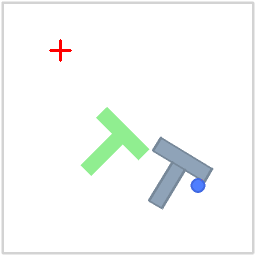

In [10]:
# Get first observation
obs, info = env.reset()

# Keep a queue of last obs_horizon (i.e. 2) steps of observations
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)

# Save visualization and rewards
imgs = [env.render()]
rewards = list()
done = False
step_idx = 0

max_steps = 200
with tqdm(total=max_steps, desc="Eval PushTStateEnv [Diffusion Policy]") as pbar:
    while not done:
        B = 1
        # Stack the last obs_horizon (2) number of observations.
        obs = np.stack(obs_deque)
        nobs = normalize_data(obs, stats=stats['obs'])  # normalize observation
        nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)  # device transfer

        # Infer actions: reverse diffusion process
        with torch.no_grad():
            obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)  # (B, To * A)

            # Initialize action from pure Gaussian noise.
            na_traj = torch.randn(
                (1, pred_horizon, action_dim), device=device)   # (1, Tp, A)

            # Init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # Predict noise
                noise_pred = ema_noise_pred_net_dp(
                    sample=na_traj,
                    timestep=k,
                    global_cond=obs_cond
                )

                # Reverse diffusion (denoising) step
                na_traj = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=na_traj,
                ).prev_sample

        # Unnormalize action
        na_traj = na_traj.detach().to('cpu').numpy()  # (1, Tp, A)
        na_traj = na_traj[0]  # (Tp, A)
        a_traj = unnormalize_data(na_traj, stats=stats['action'])  # (Tp, A)

        # Only take action_horizon number of actions.
        start = obs_horizon - 1
        end = start + action_horizon
        a_traj = a_traj[start:end, :]  # (Ta, A)

        # Execute action_horizon number of steps without replanning.
        for action in a_traj:
            obs, reward, done, _, info = env.step(action)  # env step
            obs_deque.append(obs)  # collect obs
            rewards.append(reward)  # collect reward for visualization
            imgs.append(env.render())  # collect image for visualization

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps: done = True
            if done: break

# print out the maximum target coverage
print('Score: ', max(rewards))

# Visualize
duration_in_ms = len(imgs) * 50  # 20 FPS
jviz.gif(imgs, time_in_ms=duration_in_ms, hold_last_frame_time_in_ms=1000) \
  .html(width=256, pixelated=False, title="Diffusion policy")

## **Ours: Streaming flow policy**

### Generating inputs and targets for conditional flow matching loss (CFM)

Consider an action chunk segment from the training dataset $\mathbf{\xi} = (a_0, a_1, \dots, a_T)$.

- `LinearlyInterpolateTrajectory(ξ, t)`: Given a trajectory $\xi: [0, 1] \to \mathcal{A}$ and time $t \in [0, 1]$, this function linearly interpolates the trajectory to compute positions and velocities. It returns:
  - `ξt`: linearly interpolated position $\xi(t)$.
  - `dξdt`: linearly interpolated velocity $\dot{\xi}(t)$.

- `SampleCFMInputsAndTargets(ξt, dξdt, t, k, σ0)`: Samples inputs and targets for the conditional flow matching loss (CFM). It returns:
  - `a`: The input action of the CFM, sampled as $a \sim \mathcal{N}\left(\xi(t), \sigma_0^2\,e^{-2kt}\right)$. (Eq. 3 in the paper).
  - `v`: The target velocity of the CFM, computed as $v = \dot{\xi}(t) - k \left(a - \xi(t) \right)$. (Eq. 2 in the paper)


These will be used to compute the conditional flow matching loss (CFM), which is simply the $L_2$-distance between the velocity $v_\theta(a, t \mid h)$ predicted by the neural network, and the target velocity $v$.

$$
\widehat{\mathcal{L}}_\mathrm{CFM} = \|v_\theta(a, t \mid h) - v\|_2^2
$$

In [11]:
def LinearlyInterpolateTrajectory(ξ, t):
    """
    Vectorized computation of positions and velocities if each trajectory
    (from a batch of trajectories) at given times for each trajectory, using
    linear interpolation.

    ξ (Tensor, dtype=float, shape=(B, T, A)): batch of action trajectories.
    t (Tensor, dtype=float, shape=(B,)): batch of times in [0, 1].

    Returns:
        ξt   (Tensor, shape=(B, A)): positions at time t
        dξdt (Tensor, shape=(B, A)): velocities at time t
    """
    B, T, A = ξ.shape

    # Compute the lower and upper limits of the bins that the time-points lie in.
    scaled_t = t * (T - 1)  # (B,) lies in [0, T-1]
    l = scaled_t.floor().long().clamp(0, T - 2)  # (B,) lower bin limits
    u = (l + 1).clamp(0, T - 1)  # (B,) upper bin limits
    λ = scaled_t - l.float()  # fractional part, lies in [0, 1]

    # Query the values of the upper and lower bin limits.
    batch_idx = torch.arange(B, device=ξ.device)  # (B,)
    ξl = ξ[batch_idx, l, :]  # (B, A)
    ξu = ξ[batch_idx, u, :]  # (B, A)

    # Linearly interpolate between bin limits to get position.
    λ = λ.unsqueeze(-1)  # (B, 1)
    ξt = ξl + λ * (ξu - ξl)  # (B, A)

    # Compute velocity as first-order hold.
    # Note that the time interval between two bins is Δt = 1 / (T-1).
    dξdt = (ξu - ξl) * (T - 1)  # (B, A)

    return ξt, dξdt  # (B, A) and (B, A)

def SampleCFMInputsAndTargets(ξt, dξdt, t, k, σ0):
    """
    Sample inputs and targets for the conditional flow matching loss (CFM)
    given positions and velocities at time t.

    This functions performs the following sampling (Eq. 2 and 3 of the paper):
        a ~ N(ξ(t), σ₀² exp(-2kt))  # (Eq. 3 in the paper)
        v = -k (a - ξ(t)) + dξdt(t)  # (Eq. 2 in the paper)

    Args:
        ξt (Tensor, shape=(B, A)): positions at time t.
        dξdt (Tensor, shape=(B, A)): velocities at time t.
        t (Tensor, shape=(B,)): times in [0, 1].
        k (float): Stabilizing gains of the conditional flow.
        σ0 (float): initial standard deviation of the noise added to the action.

    Returns:
        a (Tensor, shape=(B, A)): noised actions at time t
        v (Tensor, shape=(B, A)): noised action velocity targets at time t
    """
    # error = σ0 * torch.exp(-k*t).unsqueeze(1) * torch.randn_like(xt)
    t = t.unsqueeze(-1)  # (B, 1)
    sampled_error = σ0 * torch.exp(-k * t) * torch.randn_like(ξt)  # (B, A)
    a = ξt + sampled_error  # (B, A) ⟸ Eq. 3 in the paper
    v = -k * sampled_error + dξdt  # (B, A) ⟸ Eq. 2 in the paper

    return a, v  # (B, A) and (B, A)

### Streaming flow policy training loop

Takes about 3min 3s on an NVIDIA GeForce RTX 4090, which is about **12% faster than diffusion policy training** (see "Diffusion policy training loop" above)

If you don't want to wait, skip to the next cell to load pre-trained weights.

In [12]:
σ0 = 0.4
k = 10
num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=sfp_velocity_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=sfp_velocity_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # Device transfer
                # Note that data is already normalized in the dataset.
                nobs = nbatch['obs'].to(device)  # (B, To, O)
                naction = nbatch['action'].to(device)  # (B, Tp, A)

                # SFP integrates actions starting from the current timestep.
                # But sequences extracted from the PushTDataset include actions
                # corresponding to the previous timesteps as well (Tp includes
                # To - 1 previous actions). The next line removes those.
                ξ = naction[:, obs_horizon-1:, :]  # (B, Tp - To + 1, A)

                # Sample t uniformly from [0, 1].
                t = torch.rand(ξ.shape[0]).float().to(device)  # (B,)

                ξt, dξdt = LinearlyInterpolateTrajectory(ξ, t)  # (B, A) and (B, A)
                a, v = SampleCFMInputsAndTargets(ξt, dξdt, t, k, σ0)  # (B, A) and (B, A)
                a, v = a.unsqueeze(1), v.unsqueeze(1)  # (B, 1, A) and (B, 1, A)
                
                # Conditional flow matching (CFM) loss: Mean-squared error
                # between predicted velocity and target velocity
                v̂t = sfp_velocity_net(
                    sample=a,
                    timestep=t,
                    global_cond=nobs.flatten(start_dim=1),
                )  # (B, 1, A)
                loss = nn.functional.mse_loss(v, v̂t)  # (,) L2 loss

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(sfp_velocity_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_spf_velocity_net = sfp_velocity_net
ema.copy_to(ema_spf_velocity_net.parameters())

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

Batch:   0%|          | 0/95 [00:00<?, ?it/s]

### Loading pretrained checkpoint (optional)
Set `load_pretrained = True` to load pretrained weights.

In [13]:
load_pretrained = False
if load_pretrained:
  ckpt_path_sfp = "pusht_state_100ep_sfp.ckpt"
  if not os.path.isfile(ckpt_path_sfp):
      id = "1ImuaEbldF68sqJTidbJGRLy-fwlAjk-m"
      gdown.download(id=id, output=ckpt_path_sfp, quiet=False)

  state_dict_sfp = torch.load(ckpt_path_sfp, map_location='cuda')
  ema_spf_velocity_net = sfp_velocity_net
  ema_spf_velocity_net.load_state_dict(state_dict_sfp)
  print('Pretrained SFP weights loaded.')
else:
  print("Skipped pretrained weight loading for SFP.")

Skipped pretrained weight loading for SFP.


### Streaming flow policy: Inference
The rollout for 200 steps takes about 1.2s on an NVIDIA GeForce RTX4090, which is **5x times faster** than Diffusion Policy which needs about 6s. (see the Diffusion Policy inference section above)

Eval PushTStateEnv [Streaming Flow Policy]:   0%|          | 0/200 [00:00<?, ?it/s]

Score:  0.9608730642969318



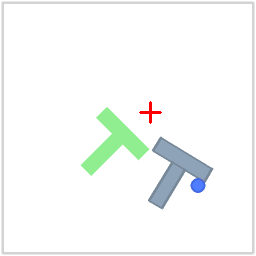

In [15]:
# Get first observation
obs, info = env.reset()

# Keep a queue of last 2 steps of observations
obs_deque = collections.deque([obs] * obs_horizon, maxlen=obs_horizon)

# Save visualization and rewards
imgs = [env.render()]
rewards = list()
done = False
step_idx = 0

# Since we are at the beginning of the episode, extract the pusher state from
# the current observation, normalize it, and use it as the "action predicted
# from the previous chunk".
a = obs[:action_dim]  # (A,)
na = normalize_data(a, stats=stats['action'])  # (A,)
na = torch.from_numpy(na).to(device, dtype=torch.float32)  # (A,)
na_from_prev_chunk = na.unsqueeze(0).unsqueeze(0)  # (1, 1, A)

max_steps = 200
with tqdm(total=max_steps, desc="Eval PushTStateEnv [Streaming Flow Policy]") as pbar:
    while not done:
        # Stack the last obs_horizon (2) number of observations
        obs = np.stack(obs_deque)  # (To, O)
        nobs = normalize_data(obs, stats=stats['obs'])  # (To, O)
        o_test = torch.from_numpy(nobs).to(device, dtype=torch.float32)  # (To, O)
        o_test = o_test.flatten().unsqueeze(0)  # (1, To * O)
 
        # Start integration for this action chunk from the last action
        # predicted from the previous chunk.
        # Note that "na_from_prev_chunk" is always normalized.
        na = na_from_prev_chunk  # (1, 1, A)

        # ODE integration step size
        Δt = 1.0 / (pred_horizon - obs_horizon)

        # Generate action chunk open loop i.e. the action chunk uses the same
        # observation for conditioning.
        # These actions can be streamed to execute in the environment asynchronously.
        with torch.no_grad():
            for i in range(action_horizon):

                # Stream the action to the environment (asynchronous step)
                a = na.detach().to('cpu').numpy().squeeze(axis=(0, 1))  # (A,)
                a = unnormalize_data(a, stats=stats['action'])  # (A,)
                obs, reward, done, _, info = env.step(a)  # env step
                obs_deque.append(obs)  # collect obs
                rewards.append(reward)  # collect reward for visualization
                imgs.append(env.render())  # collect image for visualization

                # Update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps: done = True
                if done: break

                # Euler integration step (asynchronous).
                # Compute next action in the chunk.
                t = torch.tensor(i * Δt, device=device)  # (,) current time
                nv = ema_spf_velocity_net(
                    sample=na,  # (1, 1, A)
                    timestep=t,  # (,)
                    global_cond=o_test,  # (1, To * O)
                )  # (1, 1, A)
                na = na + nv * Δt  # (1, 1, A)

        # The last action is saved for the next chunk.
        na_from_prev_chunk = na  # (1, 1, A)

# print out the maximum target coverage
print('Score: ', max(rewards))

# Visualize
duration_in_ms = len(imgs) * 50  # 20 FPS
jviz.gif(imgs, time_in_ms=duration_in_ms, hold_last_frame_time_in_ms=1000) \
  .html(width=256, pixelated=False, title="Streaming flow policy")